In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import sys
import os
import pandas as pd

sys.path.insert(0, '../src/data')
sys.path.insert(0, '../src/features')
sys.path.insert(0, '../src/models')
sys.path.insert(0, '../src/visualization')

from data_manager import DataManager
from pretreatment import create_superclasses

from ada_boost import AdaBoost
from decision_tree import DecisionTree
from k_means import KMeans
from svm import Svm
from neural_network import NeuralNetwork
from perceptron import Perceptron

from visualize import Visualize

## Prétraitement des données

In [62]:
raw_path = '../data/raw/train.csv'
test_path = '../data/raw/test.csv'
superclasses_path = '../data/processed/superclasses.csv'

In [63]:
normalized_path = '../data/processed/data_normalisee.csv'
no_outliers_path = '../data/processed/data_no_outliers_1%.csv'
no_outliers_normalized_path = '../data/processed/data_without_outliers_and_normalized.csv'
pca_path = '../data/processed/data_pca.csv'

### Superclasses

In [4]:
# create_superclasses(raw_path, superclasses_path)

## Chargement des données

In [64]:
data_path = pca_path
# data_path = superclasses_path

In [65]:
dataManager = DataManager(data_path=data_path, test_path=test_path)

constants, x_train, x_test, t_train, t_test = dataManager.load_data()
# constants.print()
t_train_onehot = dataManager.one_hot_encoding(t_train)
t_test_onehot = dataManager.one_hot_encoding(t_test)

print(f"x_train.shape: {x_train.shape}")
print(f"x_test.shape: {x_test.shape}")
print(f"t_train.shape: {t_train.shape}")
print(f"t_test.shape: {t_test.shape}")

x_train.shape: (792, 68)
x_test.shape: (198, 68)
t_train.shape: (792,)
t_test.shape: (198,)


## Préparation du modèle

### Perceptron

In [20]:
model = Perceptron(constants)
hyperparameters_choices = {
	"alpha": [0.1, 0.2, 0.01],
	"max_iter": [100, 200, 300],
}

### Réseau de neurones

In [66]:
model = NeuralNetwork(constants)
hyperparameters_choices = {
	"alpha": [1e-5],
	"max_iter": [300],
	"batch_size": [32, "auto"],
	"hidden_layer_sizes" : [(100,1), (75, 2), (50, 3)]
}
# hyperparameters_choices = {
# 	"alpha": [1e-4],
# 	"max_iter": [500],
# 	"batch_size": ["auto"],
# 	"hidden_layer_sizes" : [(100,)]
# }

### Adaboost

In [142]:
model = AdaBoost(constants)
hyperparameters_choices = {
	"n_estimators": [262, 275, 287],
	"learning_rate": [0.12, 0.025, 0.037],
 	'algorithm': ['SAMME', 'SAMME.R']
}

### SVM

In [ ]:
model = Svm(constants)
hyperparameters_choices = {		# SVM doesn't have hyperparameters in the traditional sense, but we can optimize C (regularization parameter)
	"C": [1, 10, 100, 1000]
}

### Arbre de décision

In [160]:
model = DecisionTree(constants)
hyperparameters_choices = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random']
}


### K-means

In [ ]:
model = KMeans(constants)
hyperparameters_choices = {		# KMeans doesn't have hyperparameters like SVM, but we can optimize the number of clusters (k)
	'n_clusters': [2, 3, 4, 5],
	'n_init': ["auto", 10]
}

## Apprentissage du modèle

In [67]:
# Enable to take random hyperparameters
hyperparameters = model.get_alea_hyperparameters(x_train, t_train, hyperparameters_choices)
print(f"hyperparameters: {hyperparameters}")

hyperparameters: {'alpha': 1e-05, 'max_iter': 300, 'batch_size': 32, 'hidden_layer_sizes': (100, 1)}


In [246]:
best_hyperparameters = {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}

In [52]:
best_hyperparameters = model.find_optimal_hyperparameters(x_train, t_train, hyperparameters_choices)
print(f"Les meilleurs hyperparameters: {best_hyperparameters}")

/home/timwhity/Documents/0_Sherbrooke/CoursSherbrooke/IFT712-Technique d'apprentissage/TPOussama/Projet/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/timwhity/Documents/0_Sherbrooke/CoursSherbrooke/IFT712-Technique d'apprentissage/TPOussama/Projet/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/timwhity/Documents/0_Sherbrooke/CoursSherbrooke/IFT712-Technique d'apprentissage/TPOussama/Projet/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/timwhity/D

Les meilleurs hyperparameters: {'alpha': 0.0001, 'batch_size': 'auto', 'hidden_layer_sizes': (100,), 'max_iter': 500}


/home/timwhity/Documents/0_Sherbrooke/CoursSherbrooke/IFT712-Technique d'apprentissage/TPOussama/Projet/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [68]:
model.train(x_train, t_train, best_hyperparameters)

/home/timwhity/Documents/0_Sherbrooke/CoursSherbrooke/IFT712-Technique d'apprentissage/TPOussama/Projet/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


## Tests et visualisation

In [69]:
t_pred = model.predict(x_test)
t_pred_proba = model.model.predict_proba(x_test)

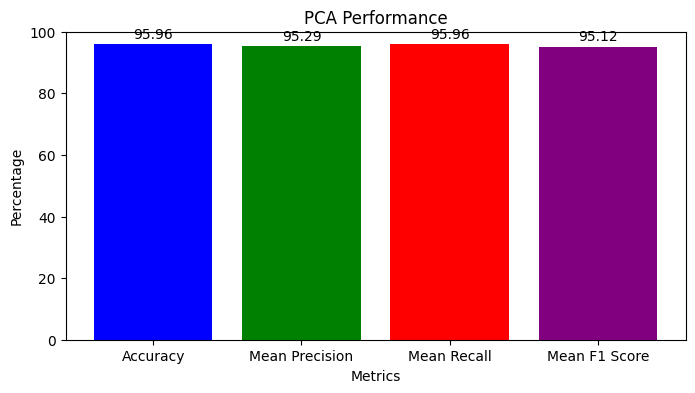

In [70]:
visualize = Visualize(constants, t_test, t_pred, t_pred_proba) #PCA
visualize.plot_mean_scores(title="PCA Performance")

/home/timwhity/Documents/0_Sherbrooke/CoursSherbrooke/IFT712-Technique d'apprentissage/TPOussama/Projet/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/timwhity/Documents/0_Sherbrooke/CoursSherbrooke/IFT712-Technique d'apprentissage/TPOussama/Projet/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


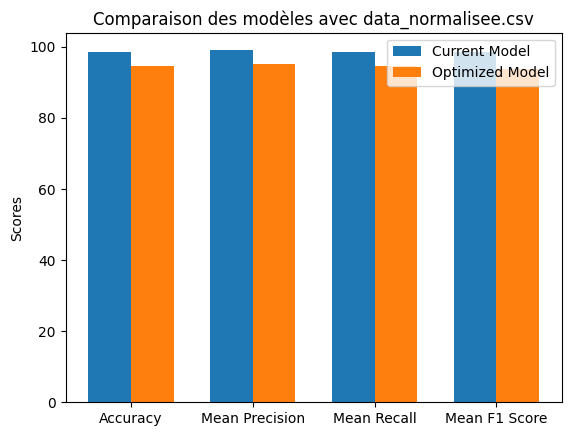

/home/timwhity/Documents/0_Sherbrooke/CoursSherbrooke/IFT712-Technique d'apprentissage/TPOussama/Projet/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


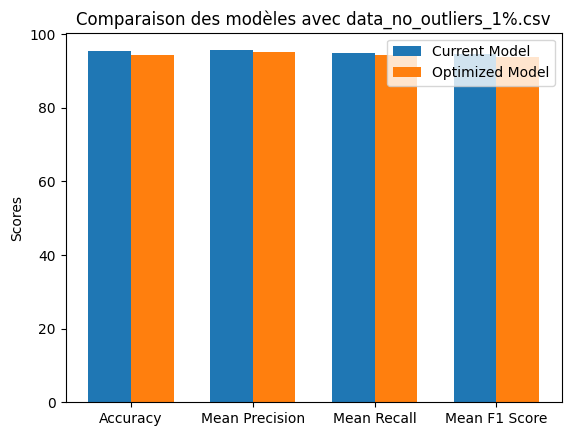

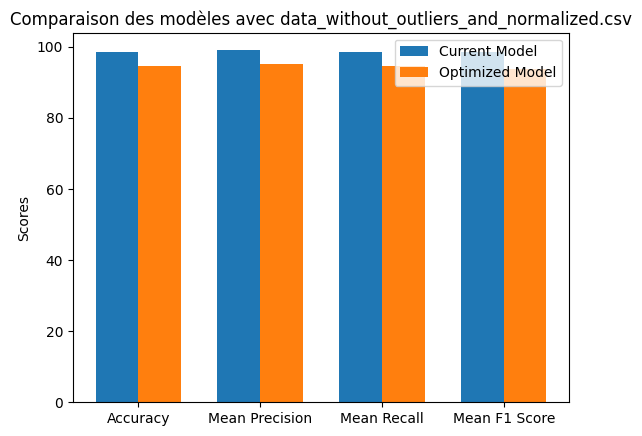

In [71]:
for data_path in [raw_path, normalized_path, no_outliers_path, no_outliers_normalized_path]:
    dataManager = DataManager(data_path=data_path, test_path=test_path)
    constants, x_train, x_test, t_train, t_test = dataManager.load_data()
    model.train(x_train, t_train, best_hyperparameters)
    t_pred = model.predict(x_test)
    t_pred_proba = model.model.predict_proba(x_test)
    if data_path == raw_path:
        visualize = Visualize(constants, t_test, t_pred, t_pred_proba)
    else:
        visualize_optimized = Visualize(constants, t_test, t_pred, t_pred_proba)
        # Extract the filename from the path
        filename = os.path.basename(data_path)
        visualize_optimized.plot_mean_scores(visualize, title=f"Comparaison des modèles avec {filename}")

### Comparaison avec/sans Paramètres optimaux

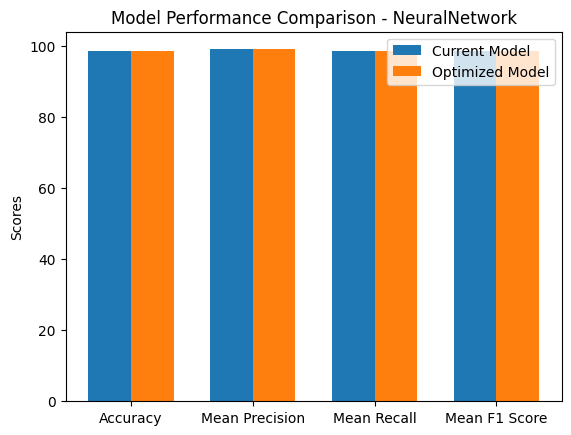

In [72]:
# Entraînement avec des hyperparamètres par défaut
model.train(x_train, t_train, {})  # Hyperparamètres vides signifient les valeurs par défaut

# Test et évaluation avec hyperparamètres par défaut
t_pred_default = model.predict(x_test)
t_pred_proba_default = model.model.predict_proba(x_test)
visualize_default = Visualize(constants, t_test, t_pred_default, t_pred_proba_default)

# Entraînement avec des hyperparamètres optimisés
model.train(x_train, t_train, best_hyperparameters)

# Test et évaluation avec hyperparamètres optimisés
visualize_optimized = Visualize(constants, t_test, t_pred, t_pred_proba)
model_name = model.__class__.__name__
visualize_default.plot_mean_scores(visualize_optimized, title=f"Model Performance Comparison - {model_name}")


/home/timwhity/Documents/0_Sherbrooke/CoursSherbrooke/IFT712-Technique d'apprentissage/TPOussama/Projet/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


NameError: name 'plt' is not defined

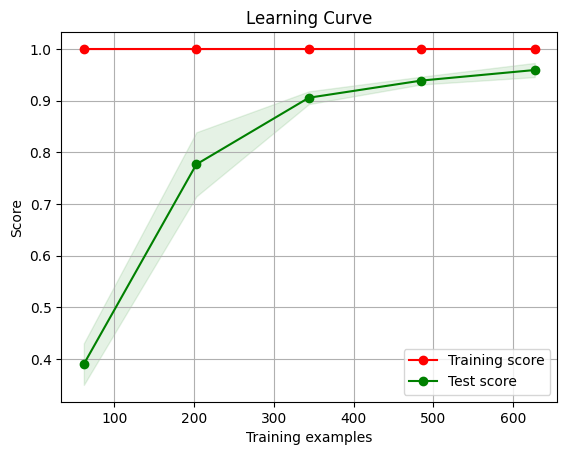

In [73]:
Visualize.plot_learning_curve(model.model, "Learning Curve", x_train, t_train, cv=5)
plt.show()

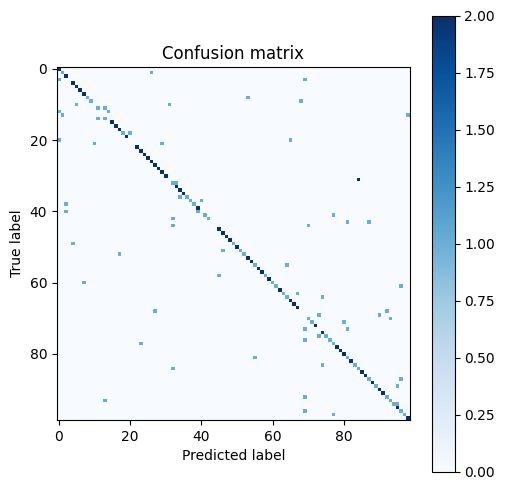

In [ ]:
visualize.plot_confusion_matrix(show_label=False)
# visualize.plot_confusion_matrix(show_label=True)

## Enregistrement des output des données de test

You must submit a csv file with the image id, all candidate species names, and a probability for each species. The order of the rows does not matter. The file must have a header and should look like the following:

```
id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,...
2,0.1,0.5,0,0.2,...
5,0,0.3,0,0.4,...
6,0,0,0,0.7,...
etc.
```

In [40]:
# Predict Test Set
clf = model.model
test = pd.read_csv('../data/raw/test.csv')

# Remove the "id" column from the test data
test_no_id = test.drop(['id'], axis=1)

test_predictions = clf.predict_proba(test_no_id)
classes = list(constants.get_labels())

# Format DataFrame
submission = pd.DataFrame(test_predictions, columns=classes)
submission.insert(0, 'id', test.id)
submission.reset_index()

# Export Submission
submission.to_csv(f'../data/submissions/submission_{clf}.csv', index=False)
submission.tail()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
589,1576,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590,1577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
591,1579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
592,1580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
593,1583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
